# Evolutionary Computation - Assignment 7: Large-scale neighborhood search
Bartosz Stachowiak 148259<br>
Andrzej Kajdasz 148273

## 1. Problem Statement

There are columns of integers representing nodes. Each row corresponds to a node and contains its x and y coordinates in a plane, as well as a cost associated with the node. There were 4 such data sets each consisting of 200 rows (each representing a single node).

Problem to solve is to choose precisely 50% of the nodes (rounding up if there is an odd number of nodes) and create a Hamiltonian cycle (a closed path) using this subset of nodes. The goal is to minimize the combined total length of the path and the total cost of the selected nodes.

To calculate the distances between nodes, the Euclidean distance formula was used and then round the results to the nearest integer. As suggested, the distances between the nodes were calculated after loading the data and placed in a matrix, so that during the subsequent evaluation of the problem, it was only necessary to read these values which reduced the cost of the operation of the algorithm.

To solve the problem the large-scale neighborhood search were used.

## 2. Pseudocode of all implemented algorithms

## 3. Results of the computational experiments

In [1]:
import json
import pathlib
import itertools

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from common import *

In [2]:
DATA_FOLDER = './data/'
OLD_RESULTS_FOLDER = f'{DATA_FOLDER}old_results/'
RESULT_FOLDER = f'{DATA_FOLDER}results/'
INSTANCE_FOLDER = f'{DATA_FOLDER}tsp_instances/'

SOLVERS = {
    "lsnp-3-r" : "LNS Steepest LS (Destruction size 3)",
    "lsno-3-r" : "LNS no LS (Perturbation size 3)",
    "lsnp-5-r" : "LNS Steepest LS (Destruction size 5)",
    "lsno-5-r" : "LNS no LS (Perturbation size 5)",
    "lsnp-10-r" : "LNS Steepest LS (Destruction size 10)",
    "lsno-10-r" : "LNS no LS (Perturbation size 10)",
    "lsnp-20-r" : "LNS Steepest LS (Destruction size 20)",
    "lsno-20-r" : "LNS no LS (Perturbation size 20)",
    "lsnp-30-r" : "LNS Steepest LS (Destruction size 30)",
    "lsno-30-r" : "LNS no LS (Perturbation size 30)",
    "lsnp-50-r" : "LNS Steepest LS (Destruction size 50)",
    "lsno-50-r" : "LNS no LS (Perturbation size 50)",
    "lsnp-75-r" : "LNS Steepest LS (Destruction size 75)",
    "lsno-75-r" : "LNS no LS (Perturbation size 75)",
}

OLD_SOLVERS = {
    "lsm-r" : "Steepest Multi Start LS",
    "lsi-3-r" : "Iterated LS (Perturbation size 3)",
    "lsi-5-r" : "Iterated LS (Perturbation size 5)",
    "lsi-10-r" : "Iterated LS (Perturbation size 10)",
    "lsi-20-r" : "Iterated LS (Perturbation size 20)",
    "lsi-30-r" : "Iterated LS (Perturbation size 30)",
    "lsi-50-r" : "Iterated LS (Perturbation size 50)",
}
SOLVERS_TO_PLOT = SOLVERS.copy()
SOLVERS = {**OLD_SOLVERS, **SOLVERS}
NUM_NODES = 200

instance_files = [path for path in pathlib.Path(INSTANCE_FOLDER).iterdir() if path.is_file()]
instance_names = [path.name[:4] for path in instance_files]
p_sizes = [3, 5, 10, 20, 30, 50, 75]

In [3]:
instances_data = {
    name: read_instance(f'{INSTANCE_FOLDER}{name}.csv')
    for name in instance_names
}

In [4]:
instances_solvers_pairs = itertools.product(instances_data.keys(), SOLVERS.keys())

all_results = {}
all_costs = {}
all_times = {}
all_stats = {}
all_no_iterations = {}

for instance, solver in instances_solvers_pairs:
    all_results[instance] = all_results.get(instance, {})
    all_costs[instance] = all_costs.get(instance, {})
    all_times[instance] = all_times.get(instance, {})
    all_stats[instance] = all_stats.get(instance, {})
    all_no_iterations[instance] = all_no_iterations.get(instance, {})
    costs = []
    times = []
    paring_results = []
    iterations = []
    for idx in range(20):
        folder = OLD_RESULTS_FOLDER if solver in OLD_SOLVERS else RESULT_FOLDER
        if solver in OLD_SOLVERS:
            solution, cost, time = read_solution(f'{folder}{instance}-{solver}-{idx}.txt')
        else:
            solution, cost, time, no_iterations = read_solution_three_feature(f'{folder}{instance}-{solver}-{idx}.txt')
            iterations.append(no_iterations)
        paring_results.append(solution)
        costs.append(cost)
        times.append(time)
        
    all_results[instance][solver] = np.array(paring_results)
    all_costs[instance][solver] = np.array(costs)
    all_stats[instance][solver] = {
        'mean': np.mean(costs),
        'std': np.std(costs),
        'min': np.min(costs),
        'max': np.max(costs),
    }
    all_times[instance][solver] = {
        'mean': np.mean(times),
        'std': np.std(times),
        'min': np.min(times),
        'max': np.max(times),
    }
    if solver not in OLD_SOLVERS:
        all_no_iterations[instance][solver] = {
            'mean': np.mean(iterations),
            'std': np.std(iterations),
            'min': np.min(iterations),
            'max': np.max(iterations),
        }

In [5]:
costs_df = pd.DataFrame(all_stats).T
time_df = pd.DataFrame(all_times).T
max_df = pd.DataFrame(all_stats).T
min_df = pd.DataFrame(all_stats).T
mean_time_df = pd.DataFrame(all_times).T
iterations_df = pd.DataFrame(all_no_iterations).T

for column in SOLVERS.keys():
    costs_df[column] = costs_df[column].apply(lambda x: f'{x["mean"]:.0f} ({x["min"]:.0f} - {x["max"]:.0f})')
    time_df[column] = time_df[column].apply(lambda x: f'{x["mean"]/1000000:.2f} ({x["min"]/1000000:.2f} - {x["max"]/1000000:.2f})')
    max_df[column] = max_df[column].apply(lambda x: x['max'])
    min_df[column] = min_df[column].apply(lambda x: x['min'])
    mean_time_df[column] = mean_time_df[column].apply(lambda x: x['mean']/1000000)
    if column not in OLD_SOLVERS:
        iterations_df[column] = iterations_df[column].apply(lambda x: f'{x["mean"]:.0f} ({x["min"]:.0f} - {x["max"]:.0f})')

for df in [costs_df, time_df, max_df, min_df, mean_time_df, iterations_df]:
    df.rename(columns=SOLVERS, inplace=True)
time_df = time_df.filter(items = SOLVERS_TO_PLOT.values())
mean_time_df = mean_time_df.filter(items  = SOLVERS_TO_PLOT.values())

### 3.1. Visualizations and statistics of cost for all dataset-algorithm pairs

In tabular form we present the Mean, Minimum and Maximum of the results of the algorithms for each dataset.

In [6]:
print("Mean (min-max) of the costs:")

best_means = {
    instance: min(all_stats[instance][solver]['mean'] for solver in SOLVERS.keys())
    for instance in instance_names
}

def apply_style(v: str, best_val: float):
    num = v.split()[0]
    try:
        num = float(num)
    except ValueError:
        return ""
    if round(num) == round(best_val):
        return "font-weight: bold; color: red"
    return ""
    


costs_df.T.style.apply(lambda x: [
    apply_style(v, best_means[x.index[i]])
    for i, v in enumerate(x)
], axis = 1)

Mean (min-max) of the costs:


,TSPA,TSPB,TSPC,TSPD
Steepest Multi Start LS,75183 (74052 - 75561),68280 (67668 - 68821),49204 (48692 - 49702),45574 (44647 - 46030)
Iterated LS (Perturbation size 3),75429 (74358 - 76834),68526 (67818 - 69610),49399 (48185 - 50088),45912 (44947 - 46405)
Iterated LS (Perturbation size 5),75306 (74636 - 76454),68551 (67643 - 69918),49219 (48704 - 49746),45853 (44963 - 47167)
Iterated LS (Perturbation size 10),75149 (74236 - 75967),68240 (67079 - 68948),49119 (48668 - 49624),45721 (45093 - 46356)
Iterated LS (Perturbation size 20),74522 (73144 - 75914),67883 (67069 - 68480),49074 (48524 - 49912),45433 (44434 - 46070)
Iterated LS (Perturbation size 30),74006 (73176 - 75303),67278 (65485 - 68793),48844 (48142 - 49671),45279 (44278 - 46134)
Iterated LS (Perturbation size 50),72888 (71562 - 74108),65858 (64501 - 66887),48144 (47409 - 48964),44591 (43218 - 45099)
LNS Steepest LS (Destruction size 3),73867 (73243 - 74894),67103 (66344 - 67789),48004 (47269 - 48791),44248 (43134 - 45115)
LNS no LS (Perturbation size 3),77886 (75193 - 80615),71089 (67948 - 74369),51282 (49100 - 53537),48209 (45444 - 51481)
LNS Steepest LS (Destruction size 5),73740 (73050 - 74539),67220 (66342 - 68508),48004 (47254 - 48848),44175 (43310 - 45166)


### 3.2 Mean number of iterations for each ILS-Instance pair

In [7]:
print("Mean (min-max) of the iterations:")
iterations_df.T

Mean (min-max) of the iterations:


,TSPA,TSPB,TSPC,TSPD
LNS Steepest LS (Destruction size 3),4081 (1859 - 6770),2901 (1338 - 5745),3215 (1499 - 4735),3052 (1094 - 4081)
LNS no LS (Perturbation size 3),5437 (2840 - 9074),5676 (2123 - 10557),4130 (1840 - 6944),3918 (2054 - 6298)
LNS Steepest LS (Destruction size 5),3433 (1443 - 6370),3728 (1261 - 5509),2376 (1351 - 4013),2222 (1078 - 3595)
LNS no LS (Perturbation size 5),4062 (2357 - 8033),5514 (1902 - 8375),3479 (1927 - 5854),2773 (1546 - 5121)
LNS Steepest LS (Destruction size 10),2498 (1168 - 4759),2509 (997 - 4713),2191 (1087 - 3366),1795 (678 - 2724)
LNS no LS (Perturbation size 10),3480 (1687 - 5759),3397 (1294 - 5882),3045 (1662 - 4321),2166 (1039 - 3605)
LNS Steepest LS (Destruction size 20),1710 (823 - 3080),1785 (626 - 3070),1489 (570 - 2200),1153 (553 - 1753)
LNS no LS (Perturbation size 20),2244 (884 - 3752),1698 (794 - 3601),1622 (687 - 2578),1427 (577 - 2244)
LNS Steepest LS (Destruction size 30),1515 (567 - 2503),1305 (497 - 2332),1131 (425 - 1484),1026 (441 - 1608)
LNS no LS (Perturbation size 30),1598 (701 - 2984),1294 (575 - 2689),1191 (609 - 1995),1172 (432 - 1674)


 ### 3.3. Visualizations and statistics of running times for all dataset-algorithm pairs

In [8]:
print("Mean (min-max) of the time [s]:")

time_df.T

Mean (min-max) of the time [s]:


,TSPA,TSPB,TSPC,TSPD
LNS Steepest LS (Destruction size 3),9.13 (9.12 - 9.16),8.64 (8.62 - 8.75),6.51 (6.50 - 6.57),5.41 (5.40 - 5.44)
LNS no LS (Perturbation size 3),9.14 (9.12 - 9.20),8.66 (8.62 - 8.76),6.51 (6.50 - 6.58),5.43 (5.40 - 5.52)
LNS Steepest LS (Destruction size 5),9.15 (9.12 - 9.21),8.63 (8.62 - 8.73),6.51 (6.50 - 6.61),5.41 (5.40 - 5.47)
LNS no LS (Perturbation size 5),9.14 (9.12 - 9.25),8.63 (8.62 - 8.75),6.51 (6.50 - 6.58),5.42 (5.40 - 5.51)
LNS Steepest LS (Destruction size 10),9.13 (9.12 - 9.21),8.63 (8.62 - 8.66),6.51 (6.50 - 6.54),5.41 (5.40 - 5.43)
LNS no LS (Perturbation size 10),9.13 (9.12 - 9.20),8.63 (8.62 - 8.71),6.51 (6.50 - 6.54),5.41 (5.40 - 5.47)
LNS Steepest LS (Destruction size 20),9.14 (9.12 - 9.21),8.63 (8.62 - 8.72),6.51 (6.50 - 6.56),5.42 (5.40 - 5.49)
LNS no LS (Perturbation size 20),9.14 (9.12 - 9.19),8.64 (8.62 - 8.72),6.51 (6.50 - 6.56),5.42 (5.40 - 5.47)
LNS Steepest LS (Destruction size 30),9.13 (9.12 - 9.20),8.64 (8.62 - 8.72),6.51 (6.50 - 6.56),5.42 (5.40 - 5.49)
LNS no LS (Perturbation size 30),9.13 (9.12 - 9.21),8.64 (8.62 - 8.70),6.51 (6.50 - 6.55),5.41 (5.40 - 5.43)


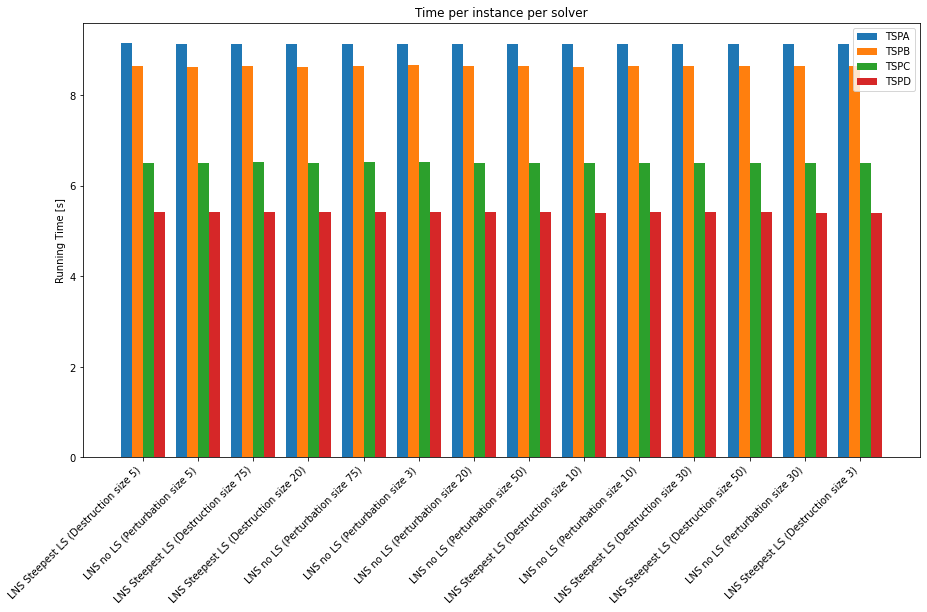

In [9]:
x_range = np.arange(len(SOLVERS_TO_PLOT))
bar_width = 0.8 / len(instances_data.keys())
mean_time_plot_df = mean_time_df.T.sort_values(by="TSPA", ascending=False).T
fig, ax = plt.subplots(figsize=(15, 8), sharey=True)
for idx, instance in enumerate(instances_data.keys()):
     ax.bar(
          x_range + idx * bar_width,
          height=mean_time_plot_df.loc[instance].values,
          width=bar_width,
          label=instance,
     )
ax.set_xticks(x_range + bar_width * (len(instances_data.keys()) - 1) / 2)
ax.set_xticklabels(mean_time_plot_df.columns, rotation=45, ha='right')
plt.title('Time per instance per solver')
plt.ylabel('Running Time [s]')
plt.legend()
plt.show()


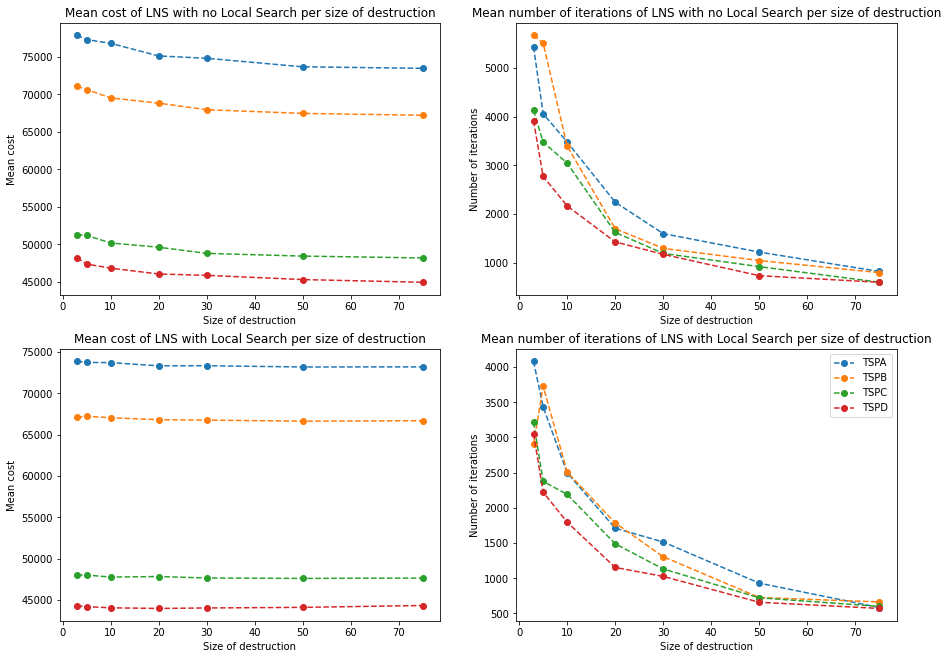

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(15, 11))

for instance in instances_data.keys():
    
    axs[0][0].plot(
        p_sizes,
        [all_stats[instance][f"lsno-{n}-r"]['mean'] for n in p_sizes],
        label=instance,
        marker='o', 
        linestyle='dashed'
    )
    axs[0][1].plot(
        p_sizes,
        [all_no_iterations[instance][f"lsno-{n}-r"]['mean'] for n in p_sizes],
        label=instance,
        marker='o', 
        linestyle='dashed'
    )
    
    axs[1][0].plot(
        p_sizes,
        [all_stats[instance][f"lsnp-{n}-r"]['mean'] for n in p_sizes],
        label=instance,
        marker='o', 
        linestyle='dashed'
    )
    axs[1][1].plot(
        p_sizes,
        [all_no_iterations[instance][f"lsnp-{n}-r"]['mean'] for n in p_sizes],
        label=instance,
        marker='o', 
        linestyle='dashed'
    )

axs[0][0].set_title('Mean cost of LNS with no Local Search per size of destruction')
axs[0][0].set_xlabel('Size of destruction')
axs[0][0].set_ylabel('Mean cost')

axs[0][1].set_title('Mean number of iterations of LNS with no Local Search per size of destruction')
axs[0][1].set_xlabel('Size of destruction')
axs[0][1].set_ylabel('Number of iterations')

axs[1][0].set_title('Mean cost of LNS with Local Search per size of destruction')
axs[1][0].set_xlabel('Size of destruction')
axs[1][0].set_ylabel('Mean cost')

axs[1][1].set_title('Mean number of iterations of LNS with Local Search per size of destruction')
axs[1][1].set_xlabel('Size of destruction')
axs[1][1].set_ylabel('Number of iterations')

plt.legend()
plt.show()

## 4. Best solutions for all datasets and algorithms

To more easily compare the results, we present the best solutions for each dataset side by side.

The weight of each node is denoted both by its size and color. The bigger and brighter the node, the higher its weight.

### 4.1 New algortithms

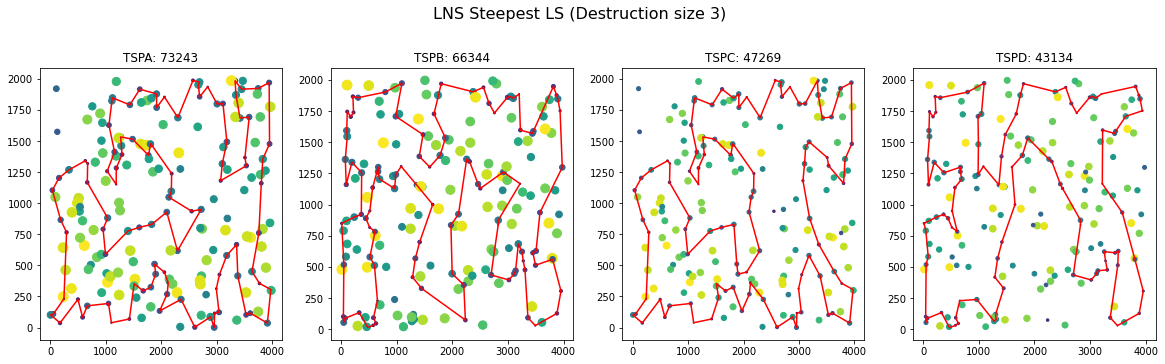

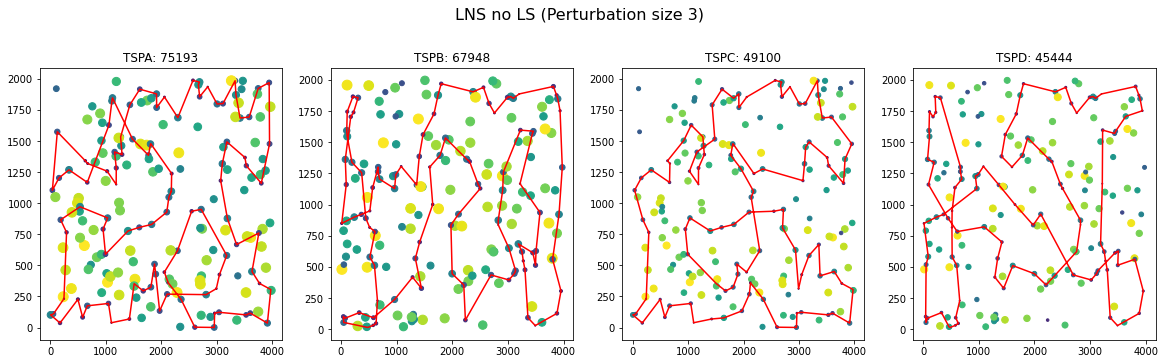

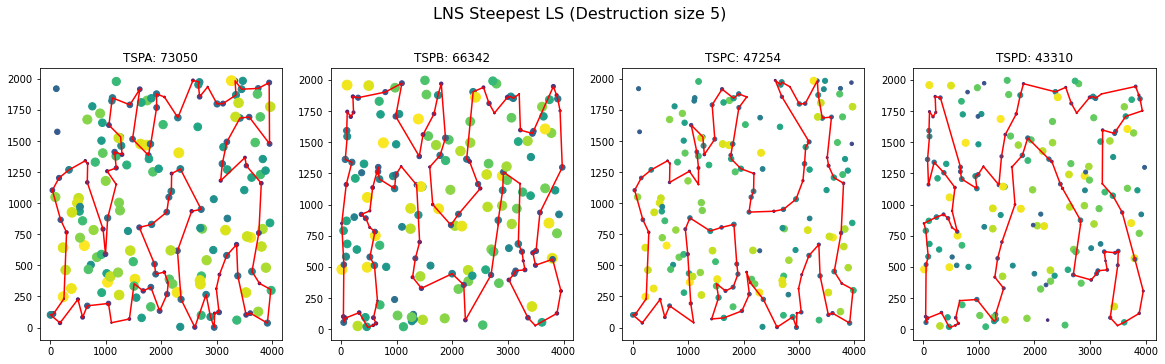

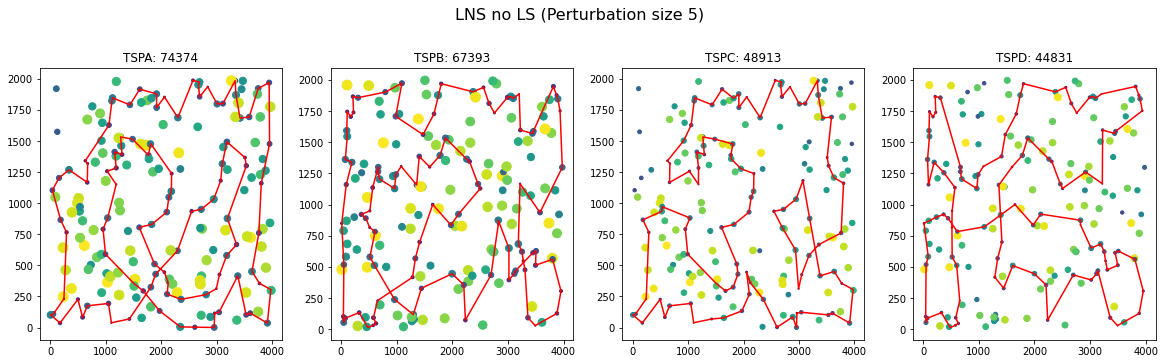

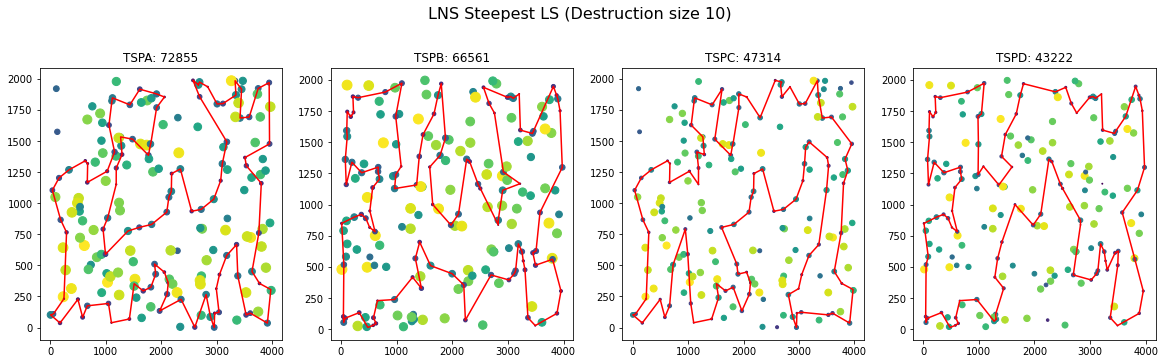

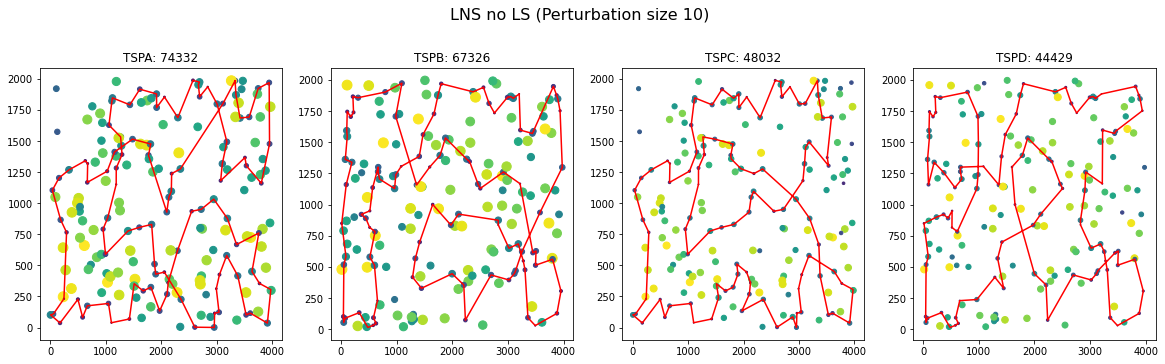

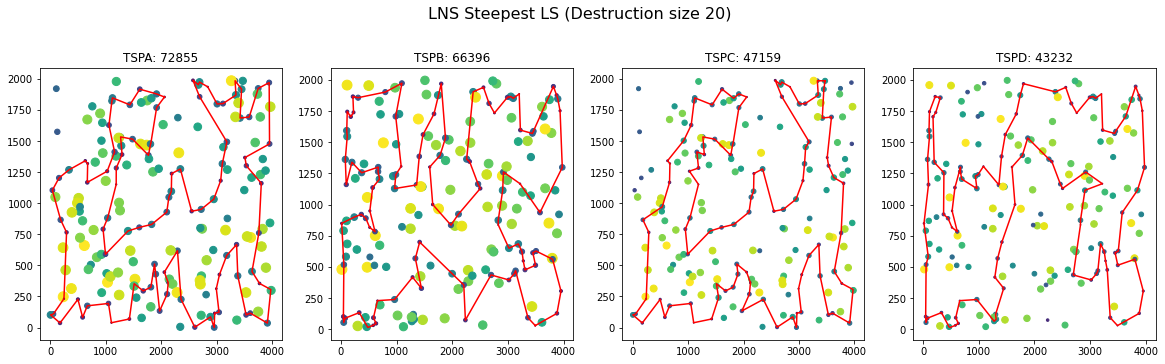

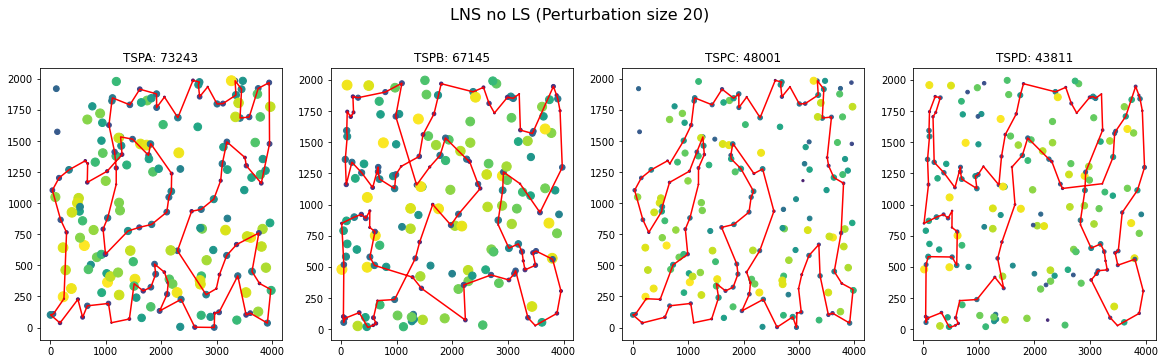

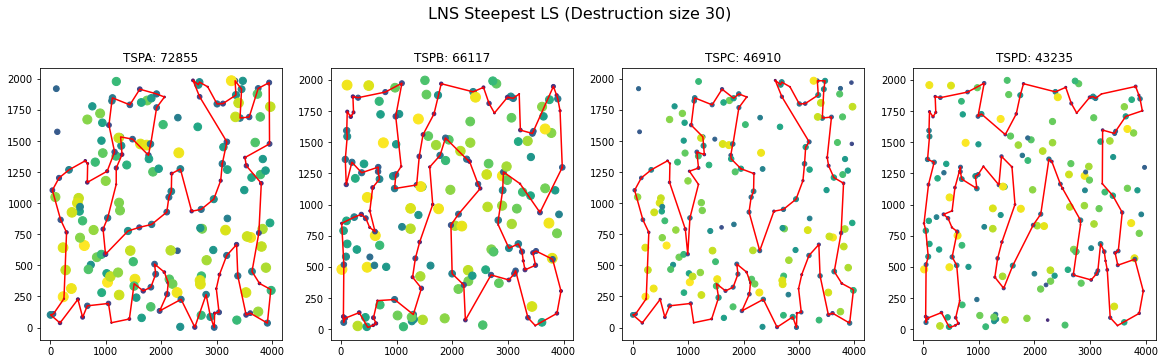

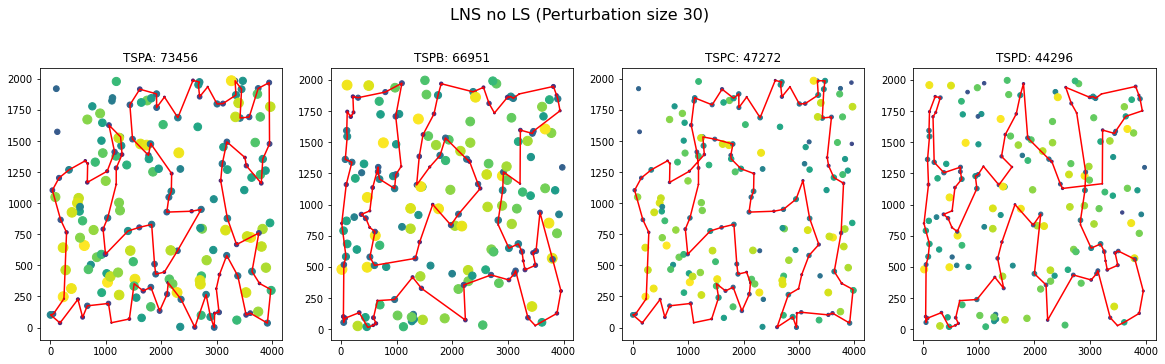

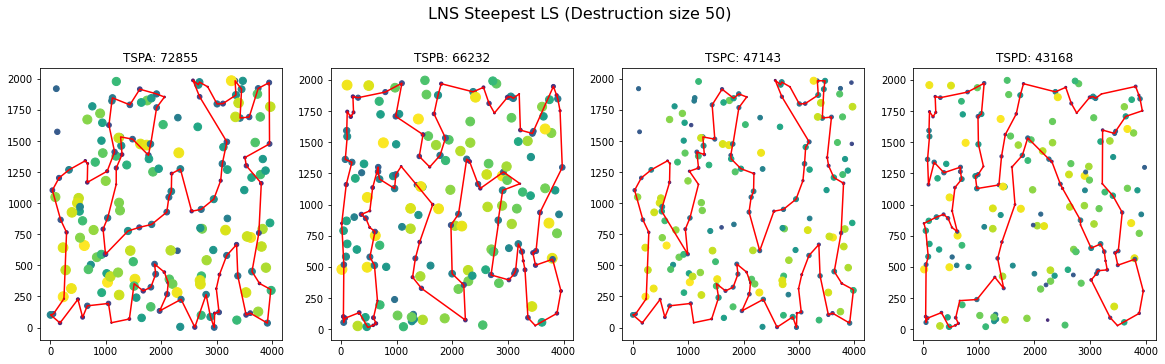

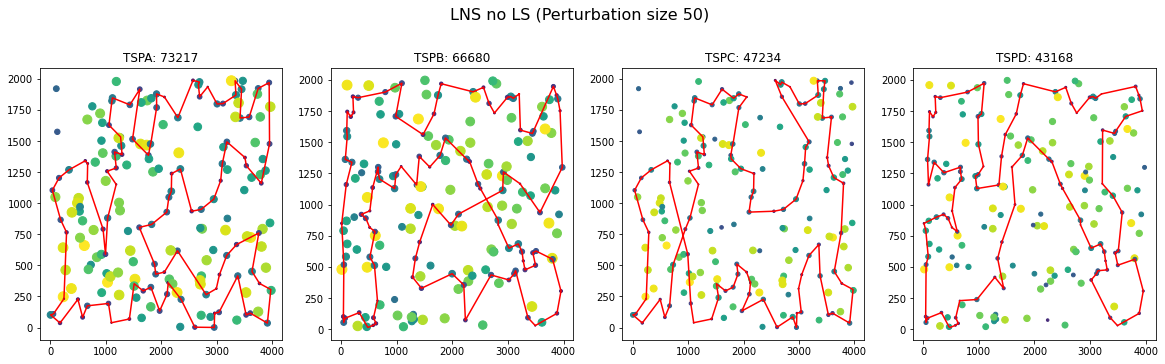

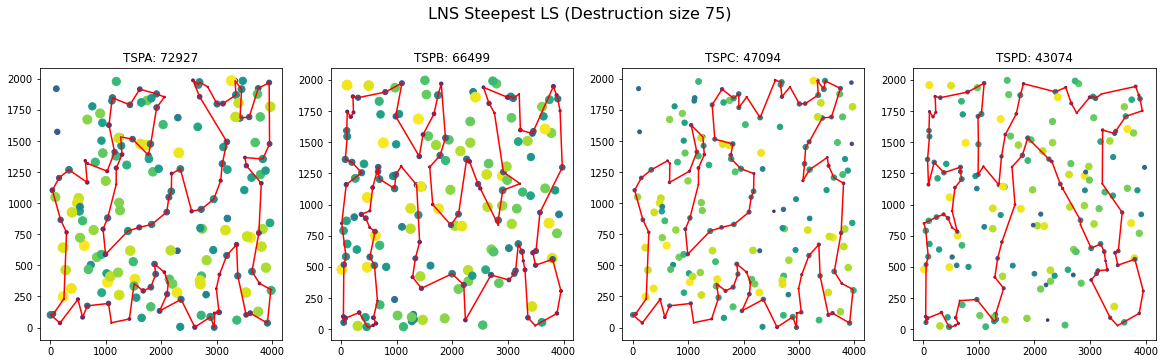

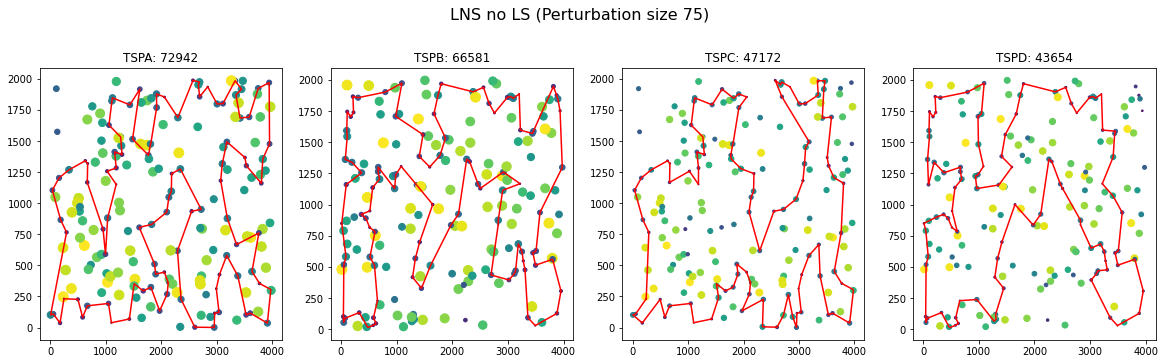

In [13]:
for solver_idx, solver in enumerate(SOLVERS_TO_PLOT.keys()):
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    for idx, instance in enumerate(instances_data.keys()):
        best_instance_idx = np.argmin(all_costs[instance][solver])
        plot_solution_for_instance(instances_data[instance], all_results[instance][solver][best_instance_idx], axs[idx])
        axs[idx].set_title(f'{instance}: {all_costs[instance][solver][best_instance_idx]:.0f}')
    fig.suptitle(f'{SOLVERS[solver]}', fontsize=16, y=1.05)
plt.show()

### 4.2 Best solution for each instance from all algorithms

TSPA
	Solver: Iterated LS (Perturbation size 50), Total cost: 71562
	 Nodes: [0, 149, 50, 43, 77, 199, 137, 41, 177, 1, 75, 189, 174, 192, 4, 114, 121, 91, 91, 91, 91, 76, 145, 55, 22, 117, 171, 21, 194, 79, 186, 127, 88, 153, 167, 101, 99, 134, 119, 109, 130, 152, 152, 11, 160, 106, 48, 48, 48, 48, 92, 26, 8, 124, 80, 31, 95, 169, 196, 135, 51, 112, 72, 98, 66, 156, 6, 141, 87, 144, 102, 154, 81, 180, 32, 62, 108, 53, 195, 155, 74, 163, 71, 20, 185, 185, 113, 36, 132, 128, 59, 96, 27, 147, 143, 159, 164, 178, 19, 69]

TSPB
	Solver: Iterated LS (Perturbation size 50), Total cost: 64501
	 Nodes: [34, 169, 66, 5, 2, 182, 163, 115, 82, 63, 8, 14, 52, 12, 107, 97, 139, 139, 193, 119, 59, 28, 166, 71, 44, 162, 150, 117, 196, 192, 21, 142, 130, 141, 148, 140, 174, 51, 91, 156, 67, 158, 114, 85, 72, 171, 58, 89, 129, 64, 159, 147, 181, 189, 47, 170, 136, 73, 185, 185, 132, 18, 16, 172, 95, 19, 190, 198, 135, 57, 80, 80, 157, 145, 153, 55, 88, 36, 25, 134, 154, 165, 37, 137, 99, 50, 24, 127, 1

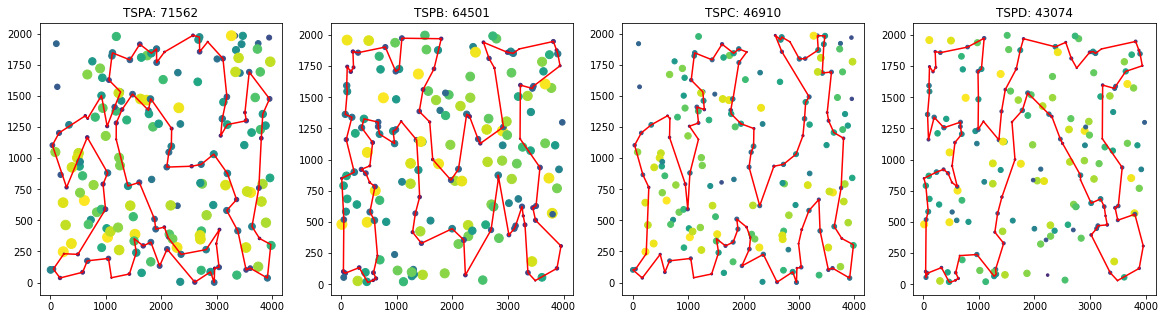

In [14]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for idx, instance in enumerate(instances_data.keys()):
    best_cost =  np.inf
    for solver_idx, solver in enumerate(SOLVERS.keys()):
         if best_cost > np.min(all_costs[instance][solver]):
                best_cost = np.min(all_costs[instance][solver])
                best_result = all_results[instance][solver][np.argmin(all_costs[instance][solver])], 
                best_solver = solver
    best_instance_idx = np.argmin(all_costs[instance][best_solver])
    plot_solution_for_instance(instances_data[instance], all_results[instance][best_solver][best_instance_idx], axs[idx])
    axs[idx].set_title(f'{instance}: {all_costs[instance][best_solver][best_instance_idx]:.0f}')
    print(instance)
    print(f'\tSolver: {SOLVERS[best_solver]}, Total cost: {best_cost}')
    nodes = list(best_result[0])
    if 0 in best_result[0]:
        zero_index = np.where(best_result[0] == 0)[0][0]
        nodes = list(best_result[0][zero_index:])+list(best_result[0][:zero_index])
    print(f'\t Nodes: {nodes}\n')
plt.show()

## 5. Source Code

[GitHub](https://github.com/Tremirre/ECP)

## 6. Conclusions



Analyzing the results and visualizations, one can come to several conclusions about the algorithms used in the task:
- Large-scale Neighbourhood Search with Local Search for each size of destruction has better mean as well as minimum cost results both than Steepest Multi Start LS. However, compared to Iterated LS, there is a big difference between the instances. For TSPA and TSPB, the best results are achieved by Iterated LS with perturbation size 50. For smaller perturbation sizes, the results are worse. For TSPC, the best mean results are obtained by the LNS Steepest LS with destruction size 50, and the best result (minimum) with destruction size 30. In case of TSPD, the best mean results are obtained by the LNS Steepest LS with destruction size 20, and the best result (minimum) with destruction size 75. 
- The large-scale neighbourhood search without local search is inferior to the version with LS, but it is noticeable that the differences diminish as the size of the destruction increases (a difference of more than three thousand to about five hundred). 
- The number of iterations varies widely and has very high minimum-to-maximum differences for both algorithms. There is also a large difference between LNS depending on the instance. For TSPA and TSPB, the differences are very high (sometimes almost double) and these differences are noticeable even for larger destruction sizes. In the case of TSPC and TSPD, the initial difference is high but becomes erased, and for size 75 this difference is not observed. 
- The larger the size of the destruction the better the results obtained even though it involves fewer iterations it increases the area of exploration which leads to finding better solutions especially with the additional use of Local Search. However, there are exceptions to this relationship for Large-scale Neighbourhood Search with Steepest LS. 
 - The destruction size of 75 is always worse than 50. 
 - In the case of TSPD instances, the deterioration of results starts already from a destruction size greater than 20.